In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import time
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from sklearn.decomposition import FastICA

In [ ]:
import torch
print(torch.__file__)

/usr/local/lib/python3.7/dist-packages/torch/__init__.py


In [ ]:
file_path='/content/Hospital_X_A1.xlsx'
# signal_n is  the number of delivered data to network at each run. (it is equivalent to n in article  )
signal_n=400

# we have 3 sensor chanels, each sensor in X direction represnts one of the chanels
sensor_channels=3

# lambdas in loss functions
lambda1=0.3
lambda2=0.2
lambda3=0.1
lambda4=0.5



epoches = 50






In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
data = pd.read_excel(file_path,sheet_name='DAQ1')
data.head()

,X,Y,X_1144,X_3184
0,-0.000170,-0.000965,0.000011,0.000040
1,-0.000167,-0.000713,0.000022,0.000001
2,-0.000134,0.000401,0.000048,-0.000052
3,-0.000109,0.000392,0.000042,0.000044
4,-0.000161,-0.000589,0.000058,-0.000135


In [ ]:
data.drop('Y',axis=1,inplace=True)
data

,X,X_1144,X_3184
0,-0.000170,0.000011,0.000040
1,-0.000167,0.000022,0.000001
2,-0.000134,0.000048,-0.000052
3,-0.000109,0.000042,0.000044
4,-0.000161,0.000058,-0.000135
...,...,...,...
200395,-0.000088,0.000021,-0.000006
200396,-0.000086,0.000029,0.000023
200397,-0.000076,0.000022,-0.000016
200398,-0.000084,0.000039,-0.000044


In [ ]:
# dt is time-step, determinded by provided information in excel file 
dt = 0.005
t = np.arange(0, 1002, dt)
t.shape

(200400,)

In [ ]:
# Independent Component Analysis with ICA
ica = FastICA(n_components=3)
icadata = ica.fit_transform(data)
data = pd.DataFrame(icadata,columns=data.columns)
data.head()

,X,X_1144,X_3184
0,0.000236,0.008098,0.002285
1,0.001186,0.007870,0.001189
2,0.003267,0.005076,-0.000486
3,0.002697,0.002766,0.002069
4,0.004117,0.007490,-0.002667


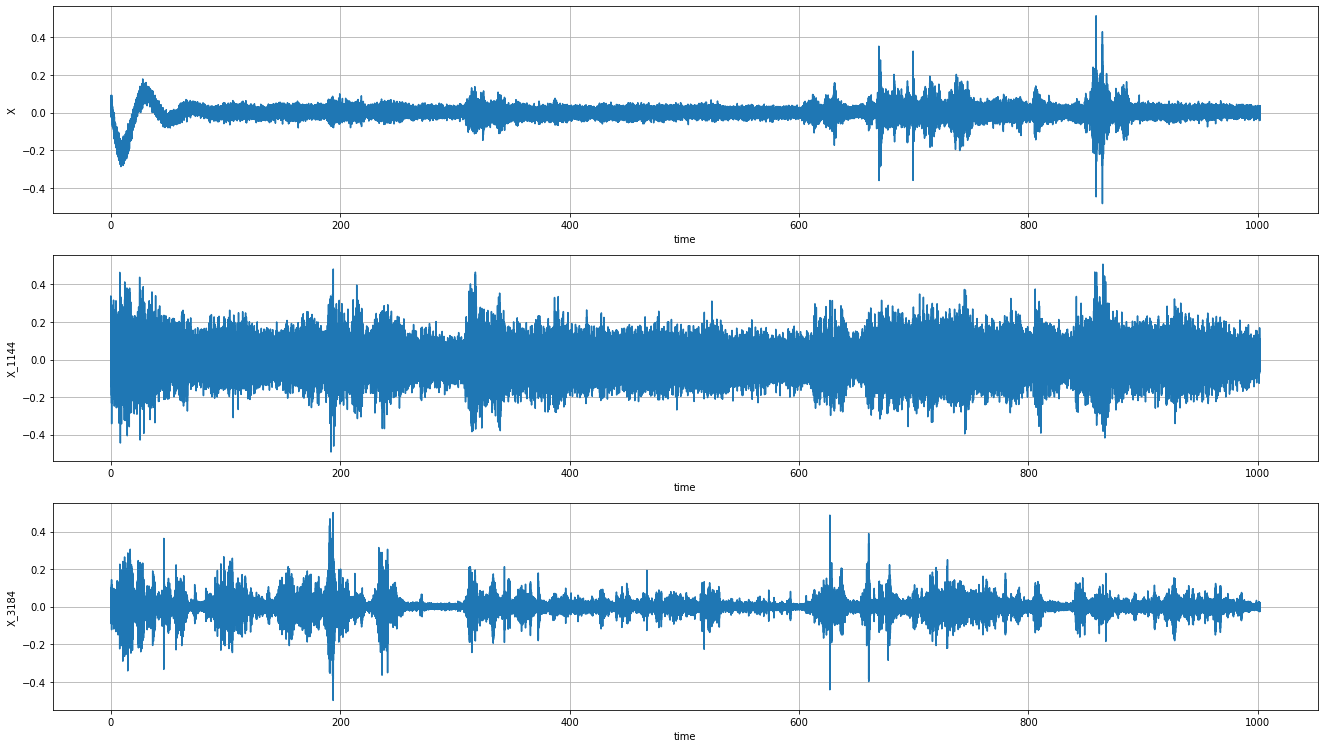

In [ ]:
#  sensor data should be represented as numpy arrays
X=data['X'].to_numpy()
# Y=data['Y'].to_numpy()
X_1144=data['X_1144'].to_numpy()
X_3184=data['X_3184'].to_numpy()


# X=noise_filtering(X,0.001)
# Y=noise_filtering(Y,0.0003)

# normalizing data 
X=(X-np.mean(X))/(np.max(X)-np.min(X))
# Y=(Y-np.mean(Y))/(np.max(Y)-np.min(Y))
X_1144=(X_1144-np.mean(X_1144))/(np.max(X_1144)-np.min(X_1144))
X_3184=(X_3184-np.mean(X_3184))/(np.max(X_3184)-np.min(X_3184))



fig, axs = plt.subplots(3, 1)

fig.set_size_inches(18.5, 10.5, forward=True)
axs[0].plot(t, X )
axs[0].set_xlabel('time')
axs[0].set_ylabel('X')
axs[0].grid(True)

# axs[1].plot(t, Y )
# axs[1].set_xlabel('time')
# axs[1].set_ylabel('Y')
# axs[1].grid(True)

axs[1].plot(t, X_1144 )
axs[1].set_xlabel('time')
axs[1].set_ylabel('X_1144')
axs[1].grid(True)

axs[2].plot(t, X_3184 )
axs[2].set_xlabel('time')
axs[2].set_ylabel('X_3184')
axs[2].grid(True)


fig.tight_layout()
plt.show()

In [ ]:


X_new=torch.Tensor(np.resize(X,(signal_n,-1,1))) 
# Y_new=torch.Tensor(np.resize(Y,(signal_n,-1,1)))

X_1144_new=torch.Tensor(np.resize(X_1144,(signal_n,-1,1)))

X_3184_new=torch.Tensor(np.resize(X_3184,(signal_n,-1,1)))

input_data=torch.cat((X_new, X_1144_new,X_3184_new), 2)
input_data.shape
#  At the end of this line we have input_data.shape[1] number of data series. each data has 
# chanel size equal to 3
# each chanel has information of signal_n time steps


torch.Size([400, 500, 3])

In [ ]:
class Network(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.fc1=nn.Linear(sensor_channels,sensor_channels)
        self.fc2=nn.Linear(sensor_channels,sensor_channels)
        self.fc3=nn.Linear(sensor_channels,sensor_channels)
    
    def forward(self,x):
            x=self.fc1(x)
            
            x=self.fc2(x)
            x=torch.tanh(x)
            x=self.fc3(x)
          
            return x
        
model=Network()
print(model)

Network(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=3, bias=True)
)


In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# These are outputs of networks middle layer 
model.fc1.register_forward_hook(get_activation('fc1'))
model.fc2.register_forward_hook(get_activation('fc2'))



In [ ]:
I_matrix=torch.eye(sensor_channels)
# print(activation['fc1'])
# print(activation['fc2'])

def my_loss(model,output,input_data):
    fc1_output = activation['fc1']
    fc2_output = activation['fc2']

    h=torch.corrcoef(torch.t(fc1_output))
    L1=lambda1* torch.max(   torch.abs(torch.sum((h-I_matrix) ,0 ))    )
    
    W=model.fc1.weight
    # !!!!!!!!!!!!!!!!!!!!!!!!warning
    # the following line may be wrong 
    W_uv=W*torch.t(W)
    second_term=lambda3*max(torch.abs(torch.sum(( W_uv-I_matrix) ,0 ))     )

    L2=0.25*lambda2*torch.max(torch.sum(torch.pow(fc1_output, 4), 0))+second_term
    
    Q=torch.corrcoef(torch.t(fc2_output))
    L3=lambda4* torch.max(    torch.abs(torch.sum((Q-I_matrix) ,0 ) )  )
    loss4 = torch.mean((output - input_data)**2)
    loss=L1+L2+L3+loss4 

    return loss


In [ ]:
# RMSprop has been set has optimizer algoritm for network

optimizer = optim.RMSprop(model.parameters(),lr=0.001)

print_every=500
steps=0
for e in range(epoches):
    running_loss=0
    for i in range(0,500) :
        data=input_data[:,i,:]
        steps+=1
        optimizer.zero_grad()
        output=model.forward(data)
        # 
        loss=my_loss(model,output,data)
        # 
        loss.backward() 
        optimizer.step()
        running_loss+=loss.item()
        
        if steps % print_every==0:
            print("Epoch: {}/{}".format(e+1,epoches),
                  "loss: {:.4f}".format(running_loss/print_every))  
            
            
            running_loss=0
            
                 
            
        

Epoch: 1/50 loss: 2.0905
Epoch: 2/50 loss: 1.8947
Epoch: 3/50 loss: 1.6501
Epoch: 4/50 loss: 1.4984
Epoch: 5/50 loss: 1.6117
Epoch: 6/50 loss: 1.7673
Epoch: 7/50 loss: 1.7949
Epoch: 8/50 loss: 1.7131
Epoch: 9/50 loss: 1.6854
Epoch: 10/50 loss: 1.6732
Epoch: 11/50 loss: 1.6601
Epoch: 12/50 loss: 1.6467
Epoch: 13/50 loss: 1.6332
Epoch: 14/50 loss: 1.6196
Epoch: 15/50 loss: 1.6057
Epoch: 16/50 loss: 1.5915
Epoch: 17/50 loss: 1.5769
Epoch: 18/50 loss: 1.5619
Epoch: 19/50 loss: 1.5466
Epoch: 20/50 loss: 1.5308
Epoch: 21/50 loss: 1.5149
Epoch: 22/50 loss: 1.4990
Epoch: 23/50 loss: 1.4832
Epoch: 24/50 loss: 1.4683
Epoch: 25/50 loss: 1.4545
Epoch: 26/50 loss: 1.4427
Epoch: 27/50 loss: 1.4336
Epoch: 28/50 loss: 1.4279
Epoch: 29/50 loss: 1.4258
Epoch: 30/50 loss: 1.4243
Epoch: 31/50 loss: 1.4262
Epoch: 32/50 loss: 1.4281
Epoch: 33/50 loss: 1.4289
Epoch: 34/50 loss: 1.4276
Epoch: 35/50 loss: 1.4239
Epoch: 36/50 loss: 1.4198
Epoch: 37/50 loss: 1.4162
Epoch: 38/50 loss: 1.4139
Epoch: 39/50 loss: 1.

In [ ]:
model.zero_grad()
# Coefficients related to W1 matrix:
model.fc1.weight

Parameter containing:
tensor([[ 0.6415, -0.6102, -0.1775],
        [-0.7021,  0.6536,  0.9442],
        [-0.8880,  0.1506,  0.8365]], requires_grad=True)

In [ ]:
# Coefficients related to W2 matrix:
model.fc2.weight

Parameter containing:
tensor([[ 0.0568,  0.9085, -0.0881],
        [-1.0741,  0.1349, -1.0324],
        [-0.7121, -1.0401,  1.3957]], requires_grad=True)

In [ ]:
# cor(H)
#  coroletion between first layer output
fc1_output = activation['fc1']
torch.corrcoef(torch.t(fc1_output))


tensor([[ 1.0000, -0.9192, -0.5041],
        [-0.9192,  1.0000,  0.7186],
        [-0.5041,  0.7186,  1.0000]])

In [ ]:
#  absolute error between 4d layer output and input 
mse_list=[]
for i in range(500): 
    data=input_data[:,i,:]  
    output=model.forward(data)
    layer4_out=output.detach().numpy()   
    mse_list.append( torch.mean (torch.abs(data-layer4_out)  ) )
torch.mean(torch.FloatTensor(mse_list)) 

tensor(0.0035)

In [ ]:
input_data.shape

torch.Size([400, 500, 3])

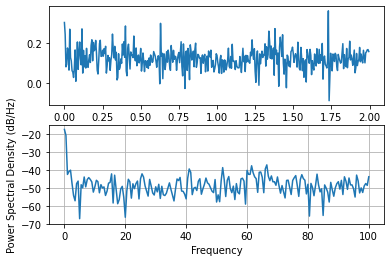

In [ ]:
data=input_data[:,0,:]     


output=model.forward(data)
fc2_output = activation['fc2']
layer3_out=fc2_output.detach().numpy()
# We can plot coressponding result to chanel i as follows 
# chanel =0
plt.subplot(211)
plt.plot(t[0:400], layer3_out[:,0])
plt.subplot(212)
# Fs: 
# The sampling frequency (samples per time unit).
#  It is used to calculate the Fourier frequencies, freqs, in cycles per time unit.
# NFFT:
# The number of data points used in each block for the FFT. 
# A power 2 is most efficient. This should NOT be used to get zero padding,
#  or the scaling of the result will be incorrect; use pad_to for this 
plt.psd(layer3_out[:,0],Fs=1/dt,NFFT=400)

plt.show()


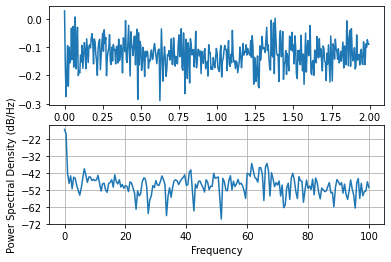

In [ ]:

# chanel =1
plt.subplot(211)
plt.plot(t[0:400], layer3_out[:,1])
plt.subplot(212)
plt.psd(layer3_out[:,1],Fs=1/dt,NFFT=400)
plt.show()

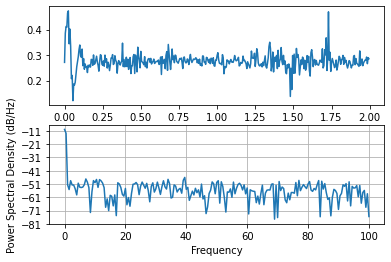

In [ ]:
# chanel =2
plt.subplot(211)
plt.plot(t[0:400], layer3_out[:,2])
plt.subplot(212)
plt.psd(layer3_out[:,2],Fs=1/dt,NFFT=400)
plt.show()

In [ ]:
data = input_data[:,0,:]
# data = data.cpu().detach().numpy()
type(data)

torch.Tensor

In [ ]:
output=model.forward(data)
layer4_out=output.detach().numpy()
layer4_out  

array([[ 0.00564682,  0.2859889 ,  0.03207939],
       [-0.08332351,  0.02213107,  0.08541487],
       [-0.12169695, -0.21073863,  0.01791213],
       ...,
       [ 0.0103969 ,  0.08585505,  0.00704817],
       [-0.01295674,  0.06375207,  0.00836793],
       [-0.0102613 ,  0.05794513,  0.00186683]], dtype=float32)

In [ ]:
data

tensor([[ 0.0036,  0.2864,  0.0336],
        [-0.0898,  0.0207,  0.0804],
        [-0.1304, -0.2174,  0.0134],
        ...,
        [ 0.0063,  0.0839,  0.0028],
        [-0.0170,  0.0619,  0.0040],
        [-0.0144,  0.0561, -0.0026]])

In [ ]:
np.corrcoef(data,layer4_out)

array([[ 1.        ,  0.26414373, -0.72378553, ...,  0.99098947,
         0.98457105,  0.9975036 ],
       [ 0.26414373,  1.        ,  0.4743342 , ...,  0.13258098,
         0.42883866,  0.33159186],
       [-0.72378553,  0.4743342 ,  1.        , ..., -0.80968563,
        -0.59187405, -0.67325217],
       ...,
       [ 0.99098947,  0.13258098, -0.80968563, ...,  1.        ,
         0.95226206,  0.97905734],
       [ 0.98457105,  0.42883866, -0.59187405, ...,  0.95226206,
         1.        ,  0.99446985],
       [ 0.9975036 ,  0.33159186, -0.67325217, ...,  0.97905734,
         0.99446985,  1.        ]])

In [ ]:
X0=torch.Tensor(np.resize(X,(200400,1)))
X1=torch.Tensor(np.resize(X_1144,(200400,1))) 
X2=torch.Tensor(np.resize(X_3184,(200400,1)))
# Creating a tensor of sensor data in all time 
all_data=torch.cat((X0,X1,X2), 1)
layer4_out=model.forward(all_data).detach().numpy()  

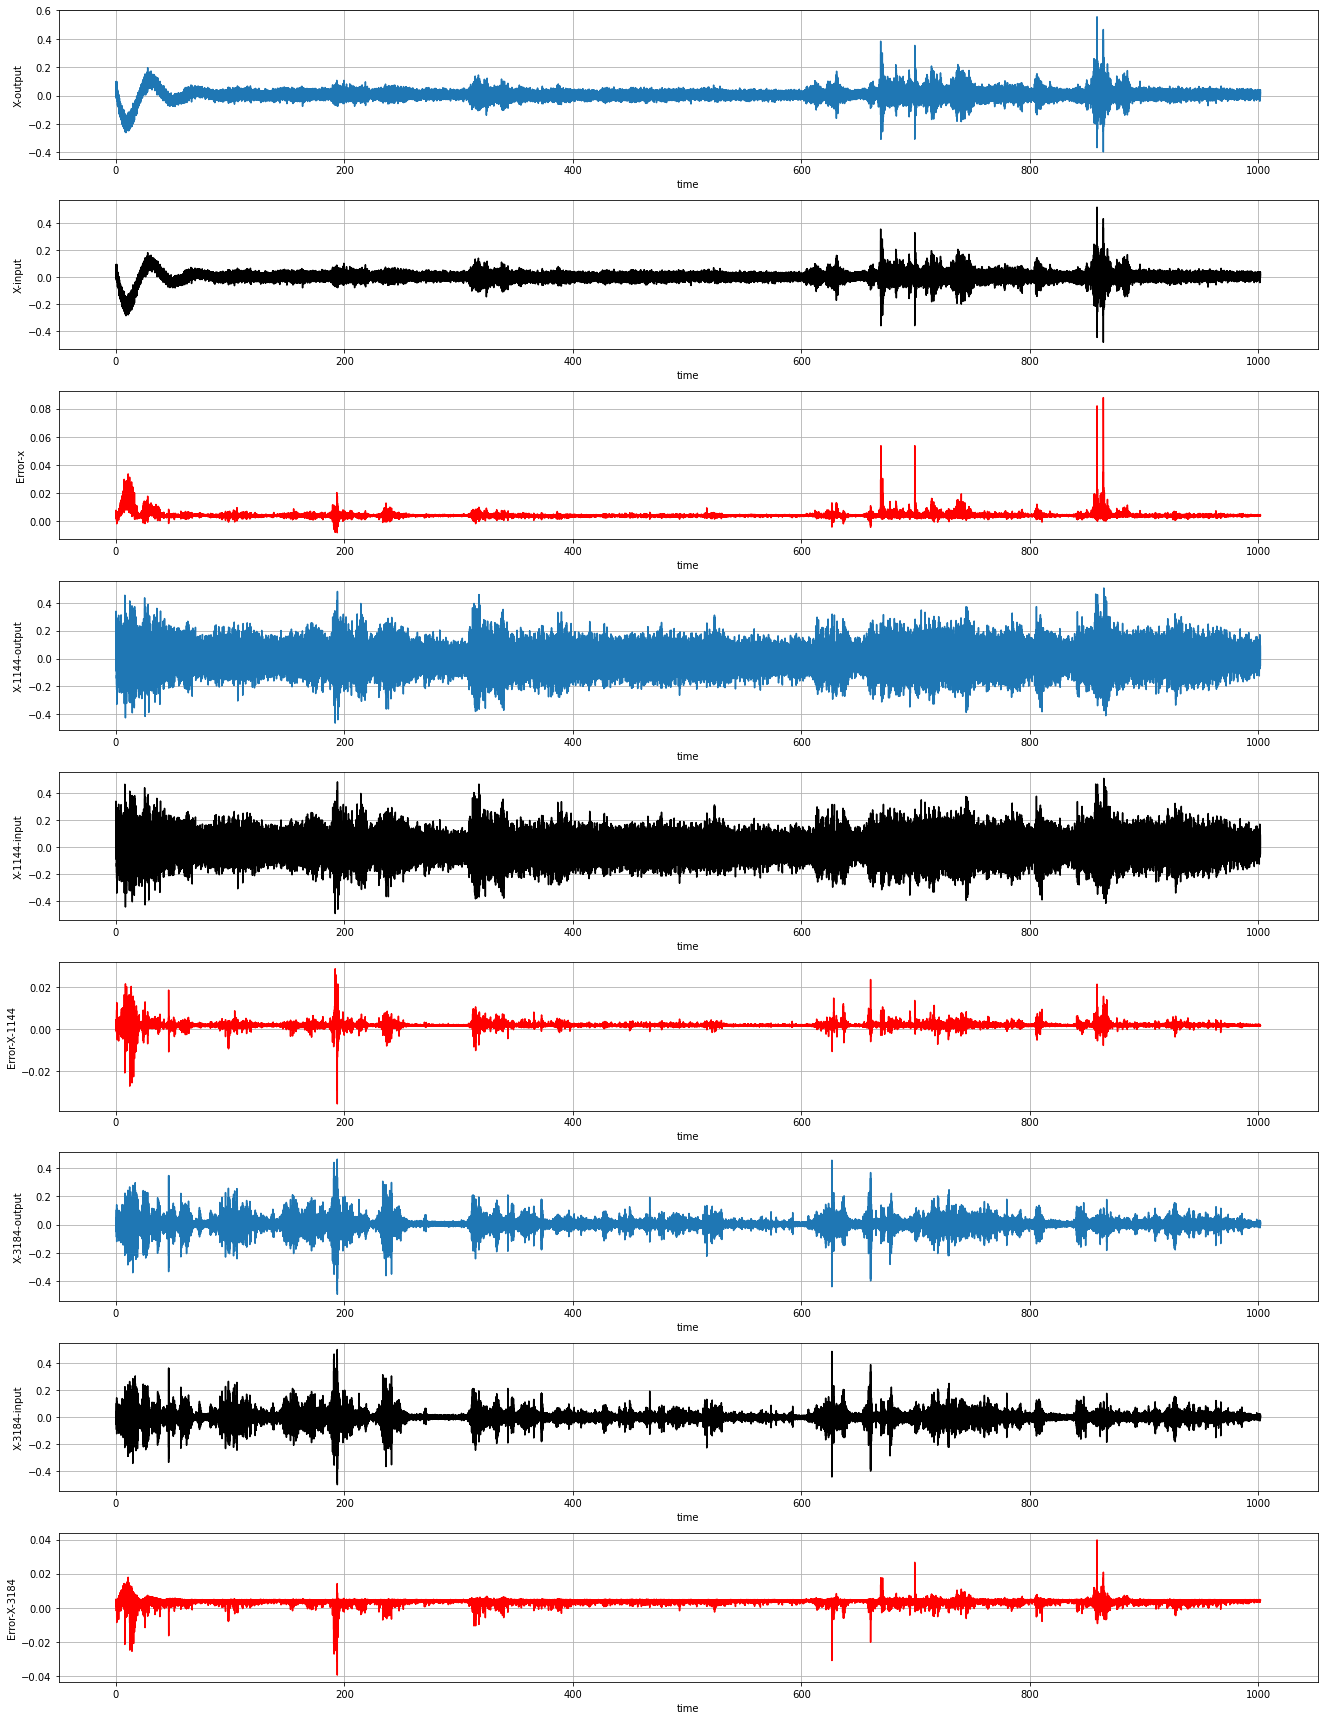

In [ ]:
#  The following plot will ilustrate our network performance to recreate input data 


fig, axs = plt.subplots(9, 1)

fig.set_size_inches(18.5, 24, forward=True)
axs[0].plot(t, layer4_out[:,0] )
axs[0].set_xlabel('time')
axs[0].set_ylabel('X-output')
axs[0].grid(True)

axs[1].plot(t, X,'k' )
axs[1].set_xlabel('time')
axs[1].set_ylabel('X-input')
axs[1].grid(True)

axs[2].plot(t, layer4_out[:,0]-X,'r' )
axs[2].set_xlabel('time')
axs[2].set_ylabel('Error-x')
axs[2].grid(True)


axs[3].plot(t, layer4_out[:,1] )
axs[3].set_xlabel('time')
axs[3].set_ylabel('X-1144-output')
axs[3].grid(True)

axs[4].plot(t, X_1144 ,'k')
axs[4].set_xlabel('time')
axs[4].set_ylabel('X-1144-input')
axs[4].grid(True)

axs[5].plot(t, layer4_out[:,1]-X_1144 ,'r')
axs[5].set_xlabel('time')
axs[5].set_ylabel('Error-X-1144')
axs[5].grid(True)


axs[6].plot(t, layer4_out[:,2] )
axs[6].set_xlabel('time')
axs[6].set_ylabel('X-3184-output')
axs[6].grid(True)

axs[7].plot(t, X_3184 ,'k')
axs[7].set_xlabel('time')
axs[7].set_ylabel('X-3184-input')
axs[7].grid(True)

axs[8].plot(t, layer4_out[:,2]-X_3184 ,'r')
axs[8].set_xlabel('time')
axs[8].set_ylabel('Error-X-3184')
axs[8].grid(True)

fig.tight_layout()
plt.show()

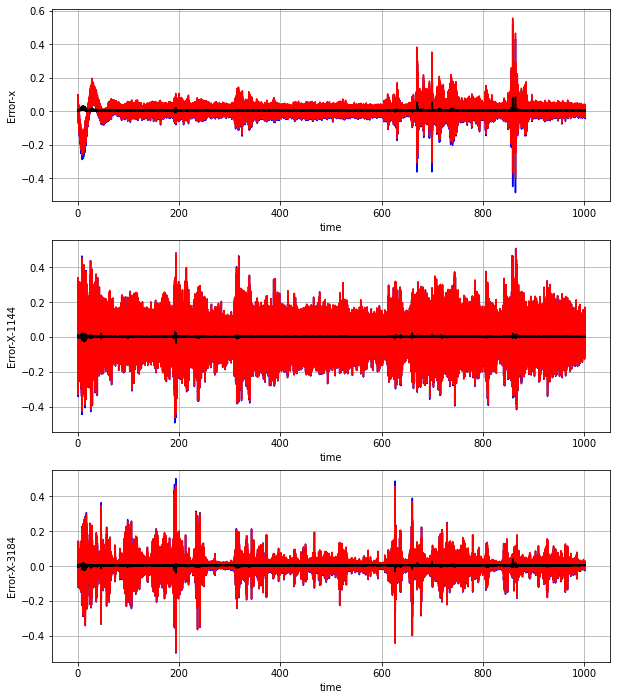

In [ ]:
fig, axs = plt.subplots(3, 1)

fig.set_size_inches(10, 12, forward=True)

axs[0].plot(t, X,'b' )
axs[0].set_xlabel('time')
axs[0].set_ylabel('X-input')
axs[0].grid(True)

axs[0].plot(t, layer4_out[:,0] ,'r')
axs[0].set_xlabel('time')
axs[0].set_ylabel('X-output')
axs[0].grid(True)


axs[0].plot(t, layer4_out[:,0]-X,'k' )
axs[0].set_xlabel('time')
axs[0].set_ylabel('Error-x')
axs[0].grid(True)

axs[1].plot(t, X_1144 ,'b')
axs[1].set_xlabel('time')
axs[1].set_ylabel('X-1144-input')
axs[1].grid(True)

axs[1].plot(t, layer4_out[:,1] ,'r')
axs[1].set_xlabel('time')
axs[1].set_ylabel('X-1144-output')
axs[1].grid(True)


axs[1].plot(t, layer4_out[:,1]-X_1144 ,'k')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Error-X-1144')
axs[1].grid(True)


axs[2].plot(t, X_3184 ,'b')
axs[2].set_xlabel('time')
axs[2].set_ylabel('X-3184-input')
axs[2].grid(True)

axs[2].plot(t, layer4_out[:,2] ,'r')
axs[2].set_xlabel('time')
axs[2].set_ylabel('X-3184-output')
axs[2].grid(True)

axs[2].plot(t, layer4_out[:,2]-X_3184 ,'k')
axs[2].set_xlabel('time')
axs[2].set_ylabel('Error-X-3184')
axs[2].grid(True)




plt.show()